# SparseEdges : computing sparseness of natural images with retina-like RFs

Let's compute the "edges" produced with symmetrical filters.

## Initialization

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%cd ../test

/Users/laurentperrinet/pool/science/BICV/SparseEdges/test


In [6]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import os
import numpy as np
np.set_printoptions(precision=2, suppress=True)
FORMATS = ['pdf', 'eps']

defining framework


In [7]:
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.datapath = 'database'
mp.pe.noise = 0.5
print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.62  0.38  0.24  0.15  0.09  0.06  0.03  0.02  0.01  0.01  0.01]


Standard edges are oriented, but one may modify that:

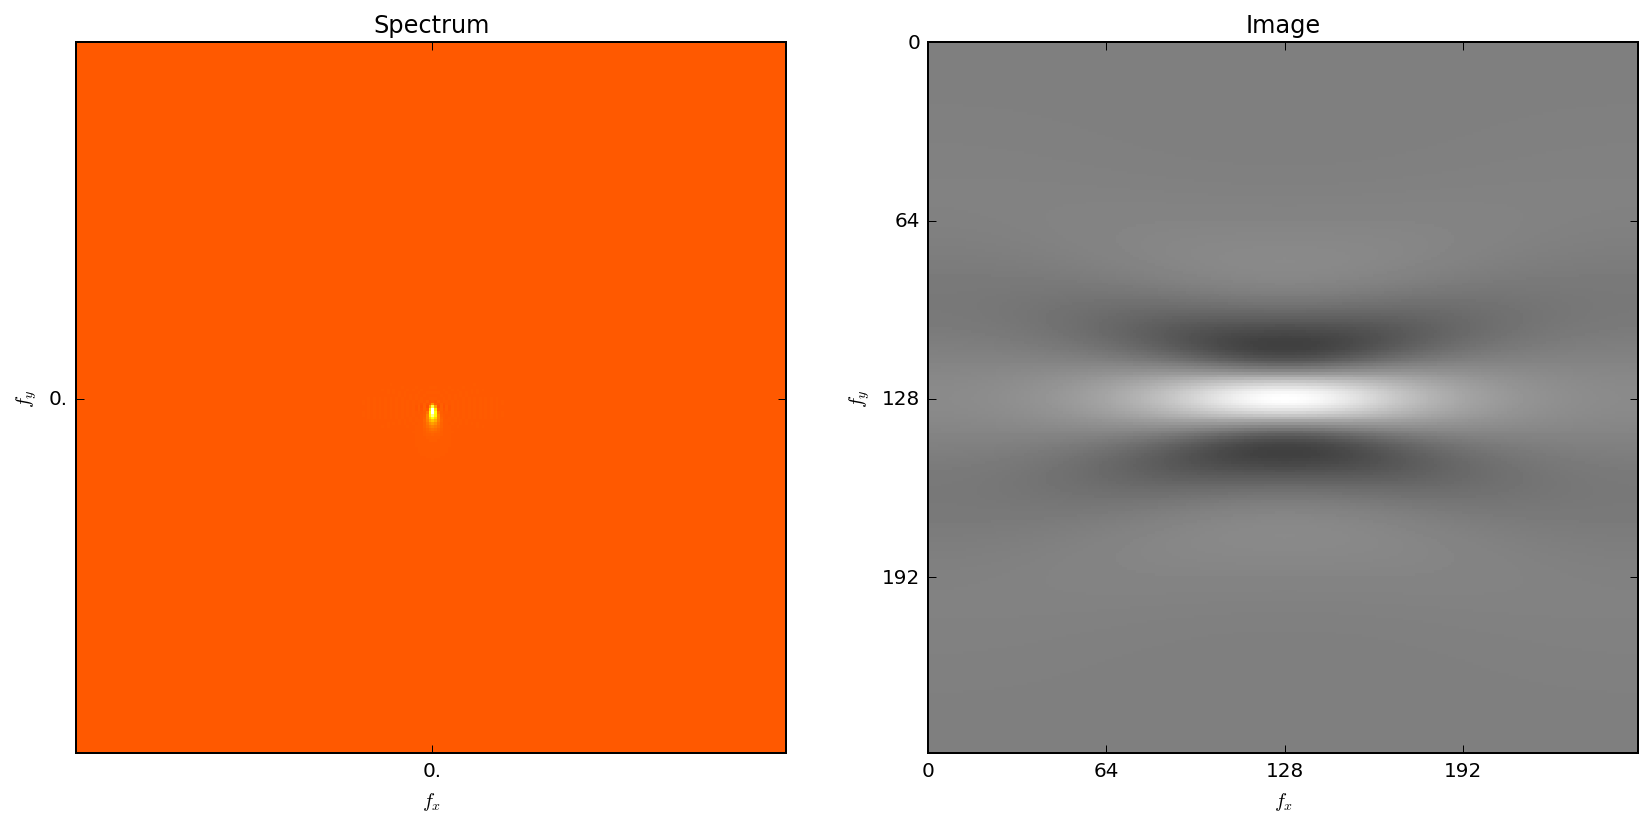

In [8]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': mp.pe.B_theta}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
#(fourier_domain(mp.normalize(np.absolute(FT_lg), center=False))+ image_domain(mp.normalize(mp.invert(FT_lg), center=False)))
fig, a1, a2 = mp.show_FT(FT_lg, axis=True)

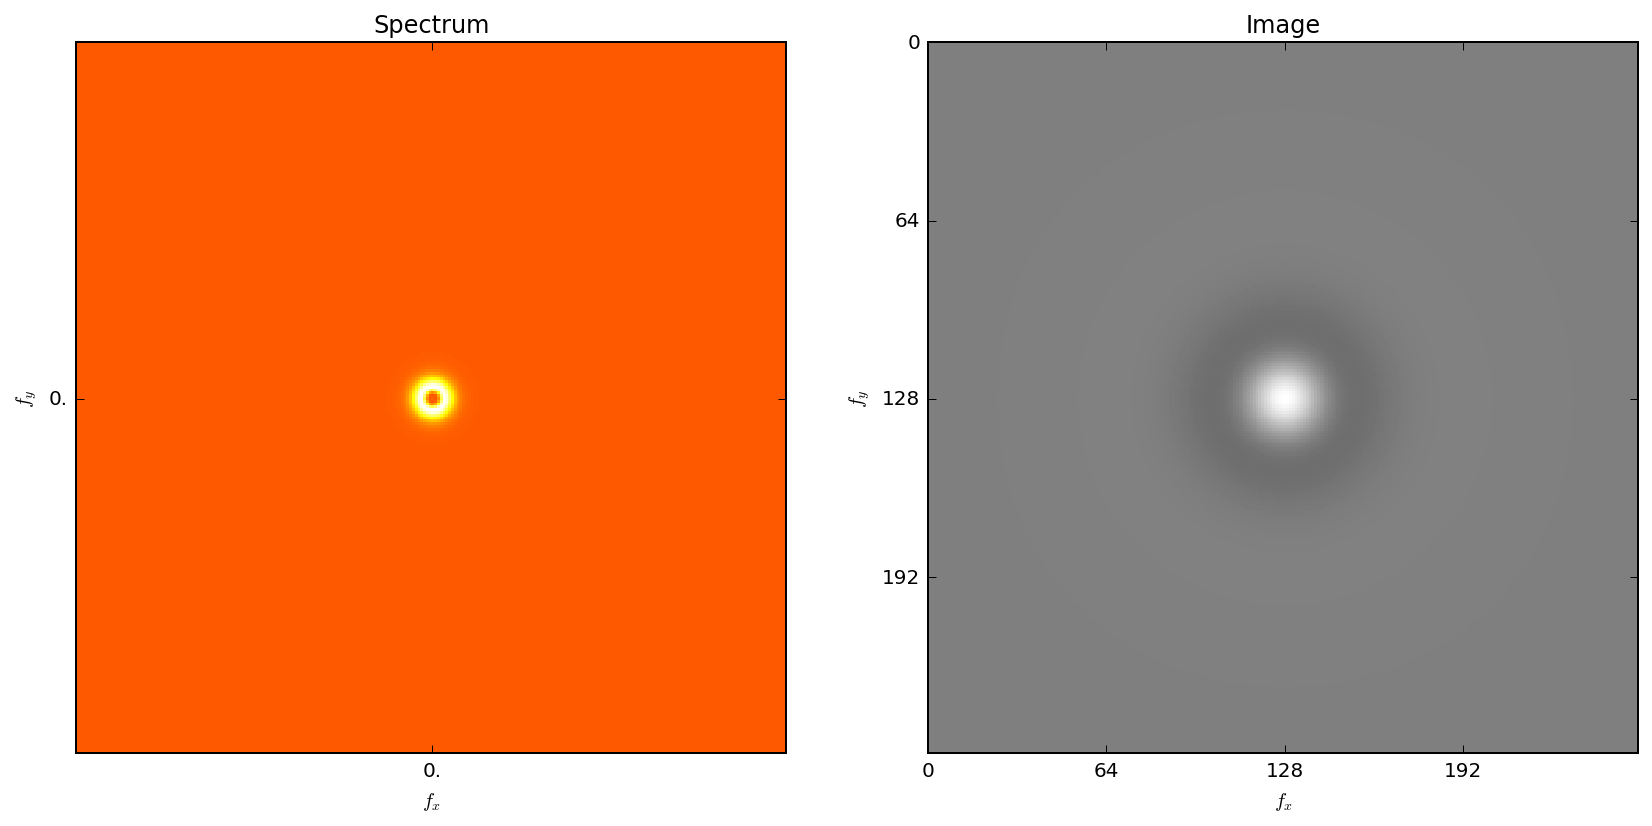

In [9]:
sf_0 = .02 # TODO .1 cycle / pixel (Geisler)
params= {'sf_0':sf_0, 'B_sf': mp.pe.B_sf, 'theta':0., 'B_theta': np.inf}
FT_lg = mp.loggabor(mp.N_X/2, mp.N_Y/2, **params)
fig, a1, a2 = mp.show_FT(FT_lg, axis=True)

When defining the framework, one thus needs only one angle:

In [10]:
print ('Range of angles: ', mp.theta*180./np.pi)
mp.pe.n_theta = 1
mp.pe.B_theta = np.inf
mp.init()
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]
Range of angles:  [ 90.]


In [11]:
mp.pe.N = 2048
image = mp.imread('https://raw.githubusercontent.com/meduz/SparseEdges/master/database/lena256.png')
name = 'retina_sparseness_example'
image = mp.normalize(image, center=True)
matname = os.path.join(mp.pe.matpath, name + '.npy')
try:
    edges = np.load(matname)
except:
    edges, C_res = mp.run_mp(image, verbose=False)
    np.save(matname, edges)    

image_rec = mp.reconstruct(edges, mask=True)        

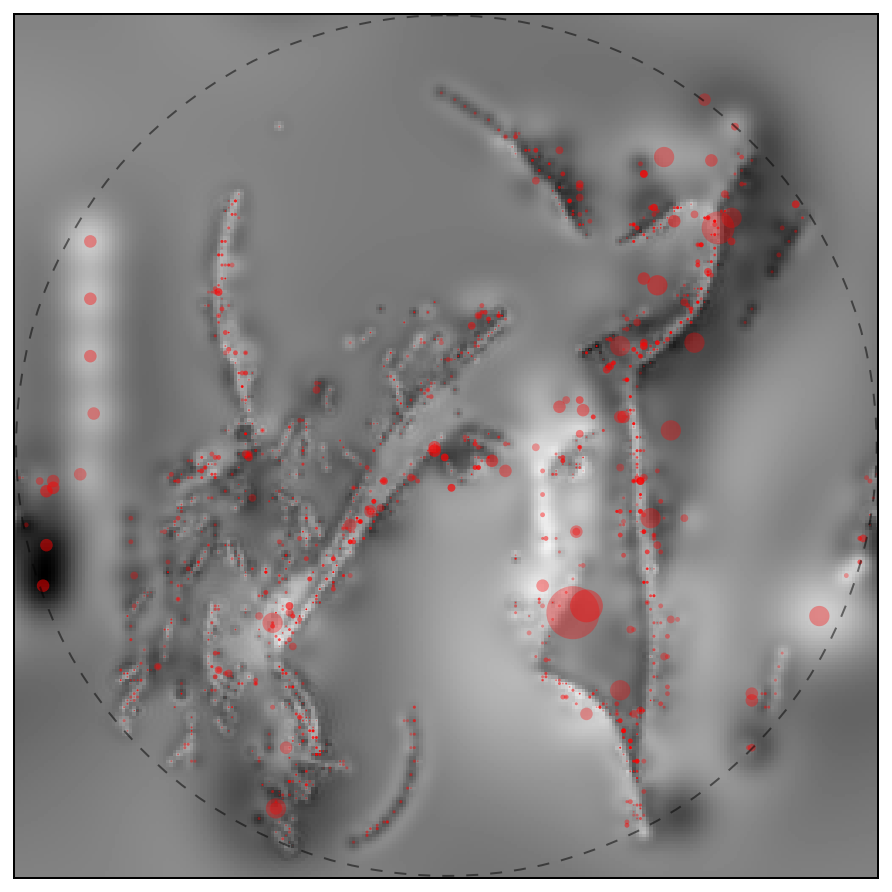

In [12]:
mp.pe.line_width = 0
fig, a = mp.show_edges(edges, image=mp.dewhitening(image_rec), show_phase=False, mask=True)

## Running simulations on a set of natural images

In [13]:
%%writefile ../test/experiment_retina_sparseness.py
# -*- coding: utf8 -*-
from __future__ import division, print_function
"""

$ python experiment_retina_sparseness.py

rm -fr **/retina_sparseness* **/**/retina_sparseness*

"""
import numpy as np
from SparseEdges import SparseEdges

for name_database in ['serre07_distractors']:#, 'serre07_distractors_urban', 'laboratory']:
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.datapath = '../../SLIP/database/'
    mp.pe.N_image = 100
    mp.pe.N = 2048
    mp.pe.n_theta = 1
    mp.pe.B_theta = np.inf
    mp.init()

    # control experiment
    imageslist, edgeslist, RMSE = mp.process(exp='retina_sparseness', name_database=name_database)



Overwriting ../test/experiment_retina_sparseness.py


In [14]:
%run experiment_retina_sparseness.py

## Analysing results


First, we retrieve edges from a prior edge extraction

In [15]:
experiment = 'retina_sparseness'
name_database='serre07_distractors'
imageslist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)


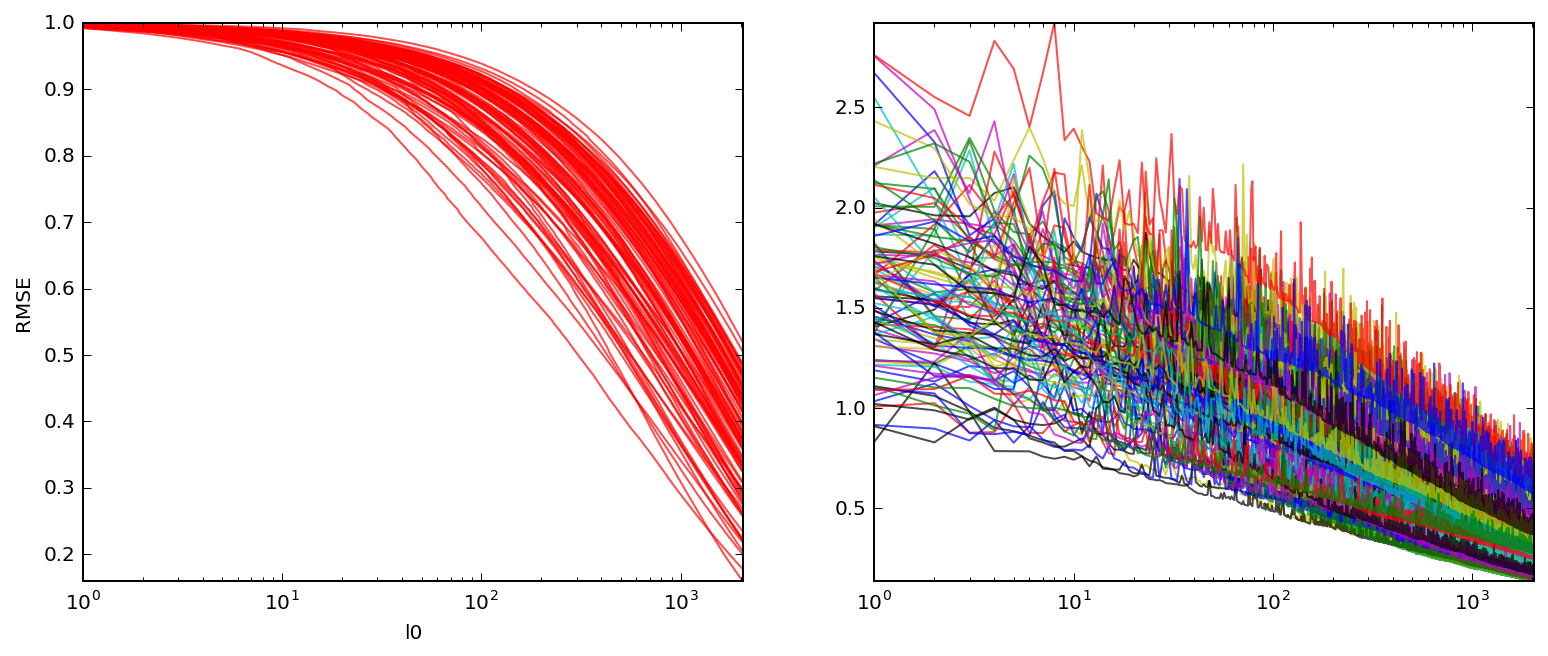

In [16]:
fig, [A, B] = plt.subplots(1, 2, figsize=(13, 5), subplot_kw={'axisbg':'w'})
A.set_color_cycle(np.array([[1., 0., 0.]]))
try:
    imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
    RMSE /= RMSE[:, 0][:, np.newaxis]
    #print RMSE.shape, edgeslist.shape
    value = edgeslist[4, ...]
    #value /= value[0, :][np.newaxis, :]
    value /= RMSE[:, 0][np.newaxis, :]

    B.semilogx( value, alpha=.7)

    A.semilogx( RMSE.T, alpha=.7)
    A.set_xlabel('l0')
    A.axis('tight')
    B.axis('tight')
    _ = A.set_ylabel('RMSE')
except Exception as e:
    print('Failed to plot experiment %s with error : %s ' % (experiment, e) )


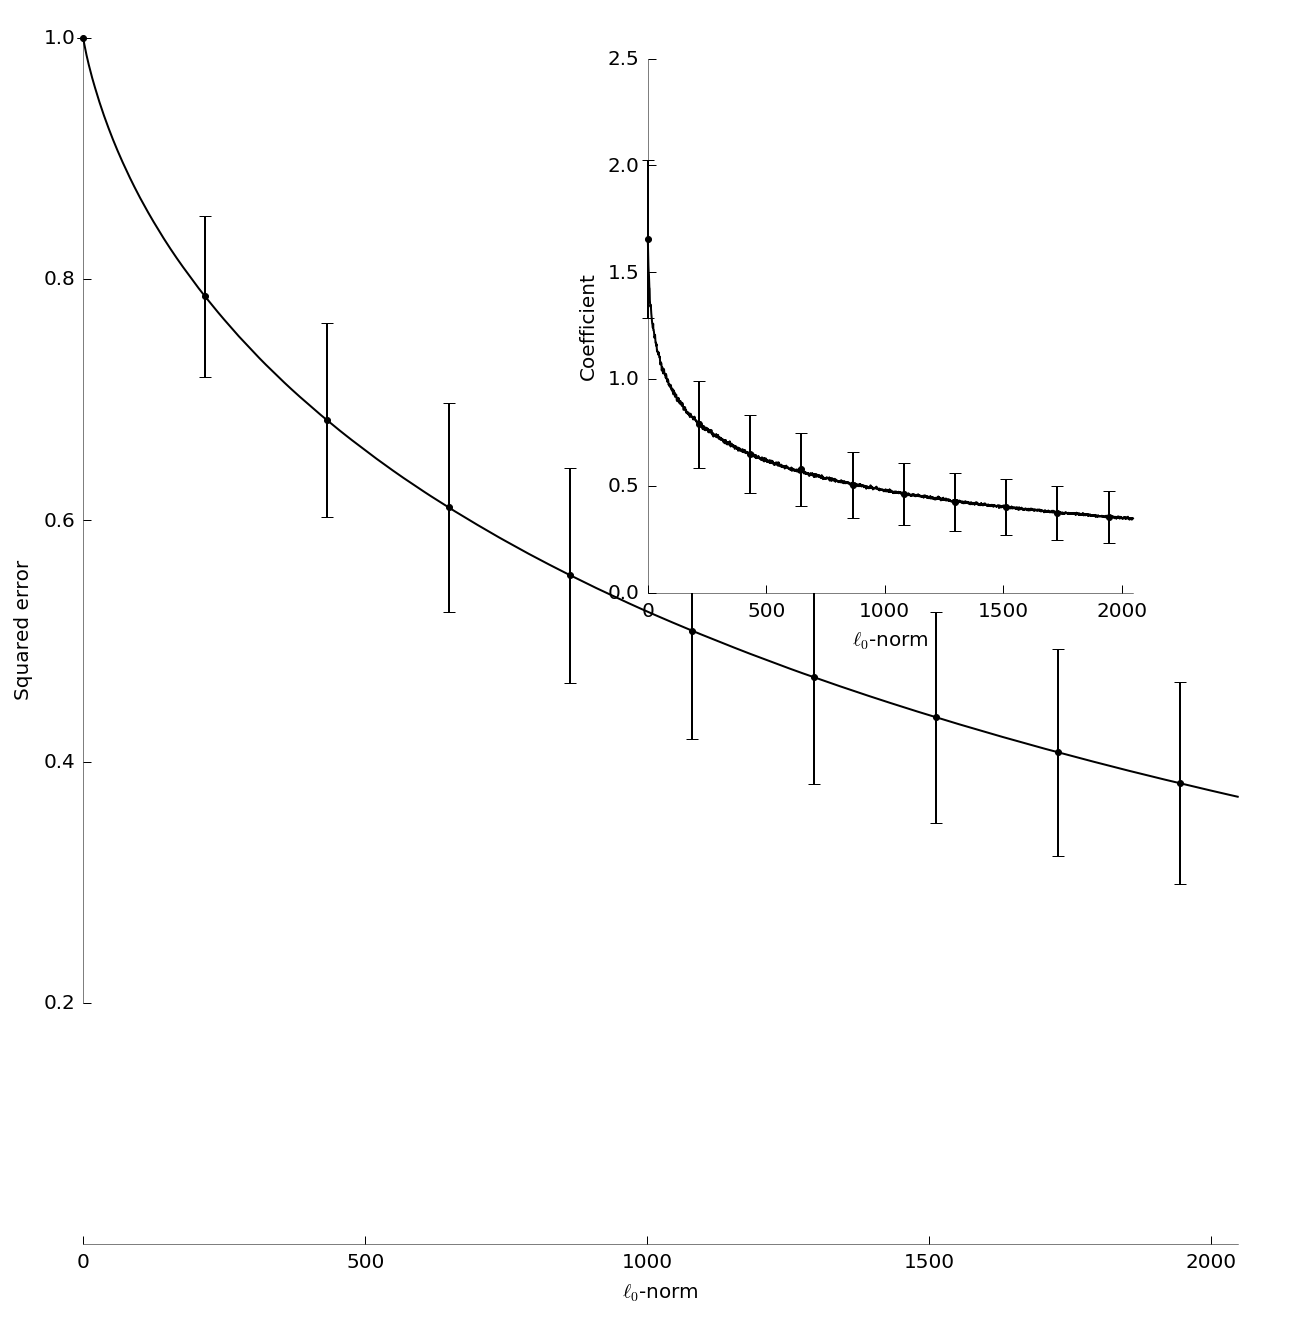

In [17]:
fig_width = 15
fig = plt.figure(figsize=(fig_width/1.618, fig_width/1.618))
fig, a, ax = mp.plot(mps=[mp], experiments=[experiment], databases=[name_database], fig=fig, labels=[''], 
                  color=[0., 0., 1.], scale=False)#  

## trying different fits
!pip install lmfit

In [18]:
from lmfit.models import ExpressionModel
import numpy as np
mod = ExpressionModel('off + amp * exp(-x/x0) * sin(x*phase)')
x = np.linspace(0, 10, 501)
params = mod.make_params(off=0.25, amp=1.0, x0=2.0, phase=0.04)
y = mod.eval(params, x=x)
y

array([ 0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.26,  0.26,
        0.26,  0.26,  0.26,  0.26,  0.26,  0.26,  0.26,  0.26,  0.26,
        0.26,  0.26,  0.26,  0.26,  0.26,  0.26,  0.27,  0.27,  0.27,
        0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,
        0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,
        0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,  0.27,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,  0.28,
        0.28,  0.28,

rho= 0.998894417787 , +/-  0.000564074033024


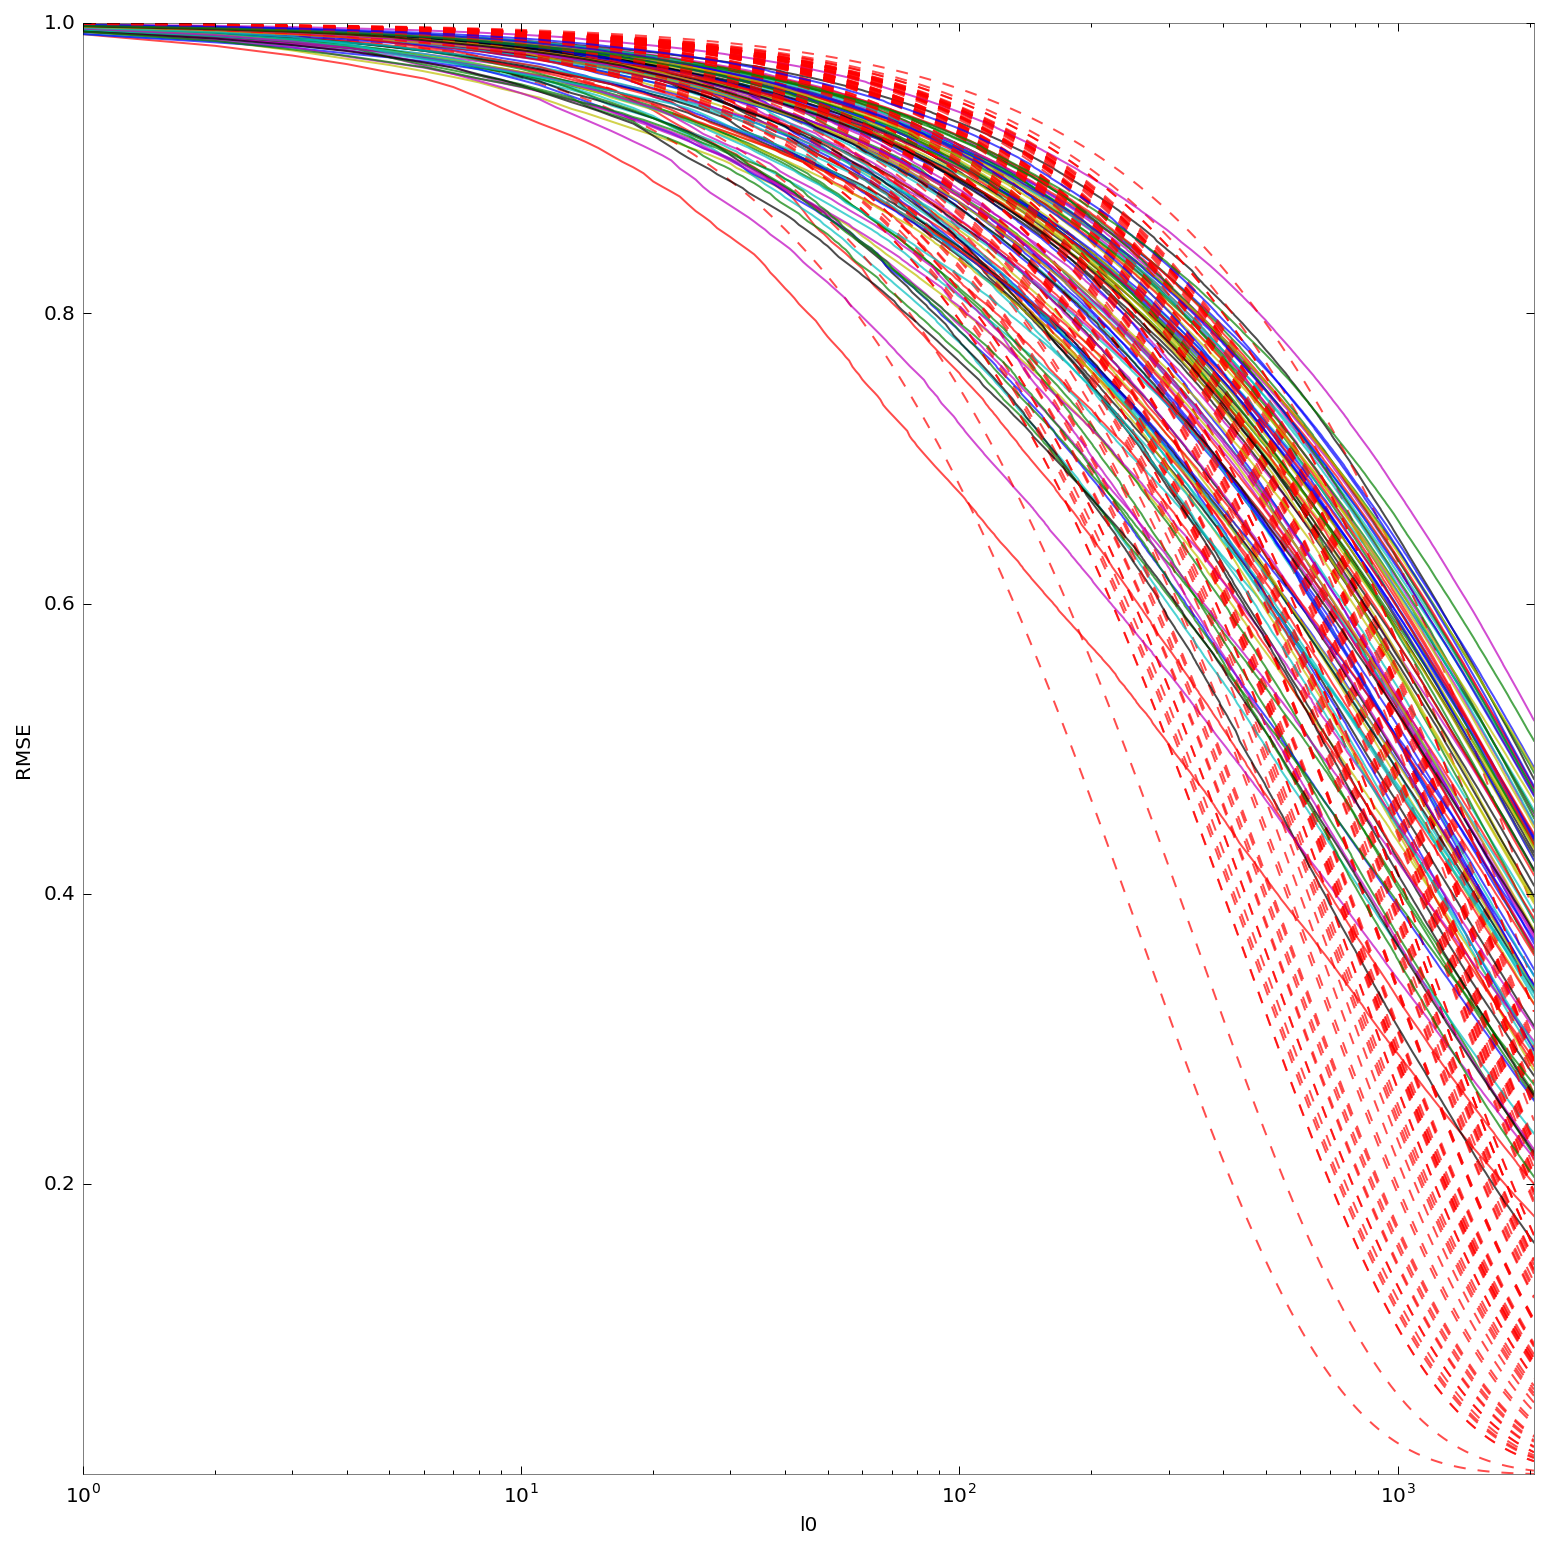

In [19]:
fig, A = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
#mod = PowerLawModel()
mod = ExpressionModel('rho**x')
RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
rho = np.zeros(RMSE.shape[0])
for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'rho':.99}
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=False, weights=1/(np.arange(N)+1))
    #print(out.fit_report(min_correl=0.25))
    rho[i_image] =  out.params.get('rho').value
    #print 'rho=', rho[i_image]
    #N_theta = np.log(threshold)/np.log(rho)
    #print N_theta
    A.semilogx( RMSE[i_image, :], alpha=.7)
    params = mod.make_params(rho=rho[i_image])
    A.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    A.set_xlabel('l0')
    A.axis('tight')
    A.axis('tight')
    _ = A.set_ylabel('RMSE')            

print ('rho=', rho.mean(), ', +/- ', rho.std())

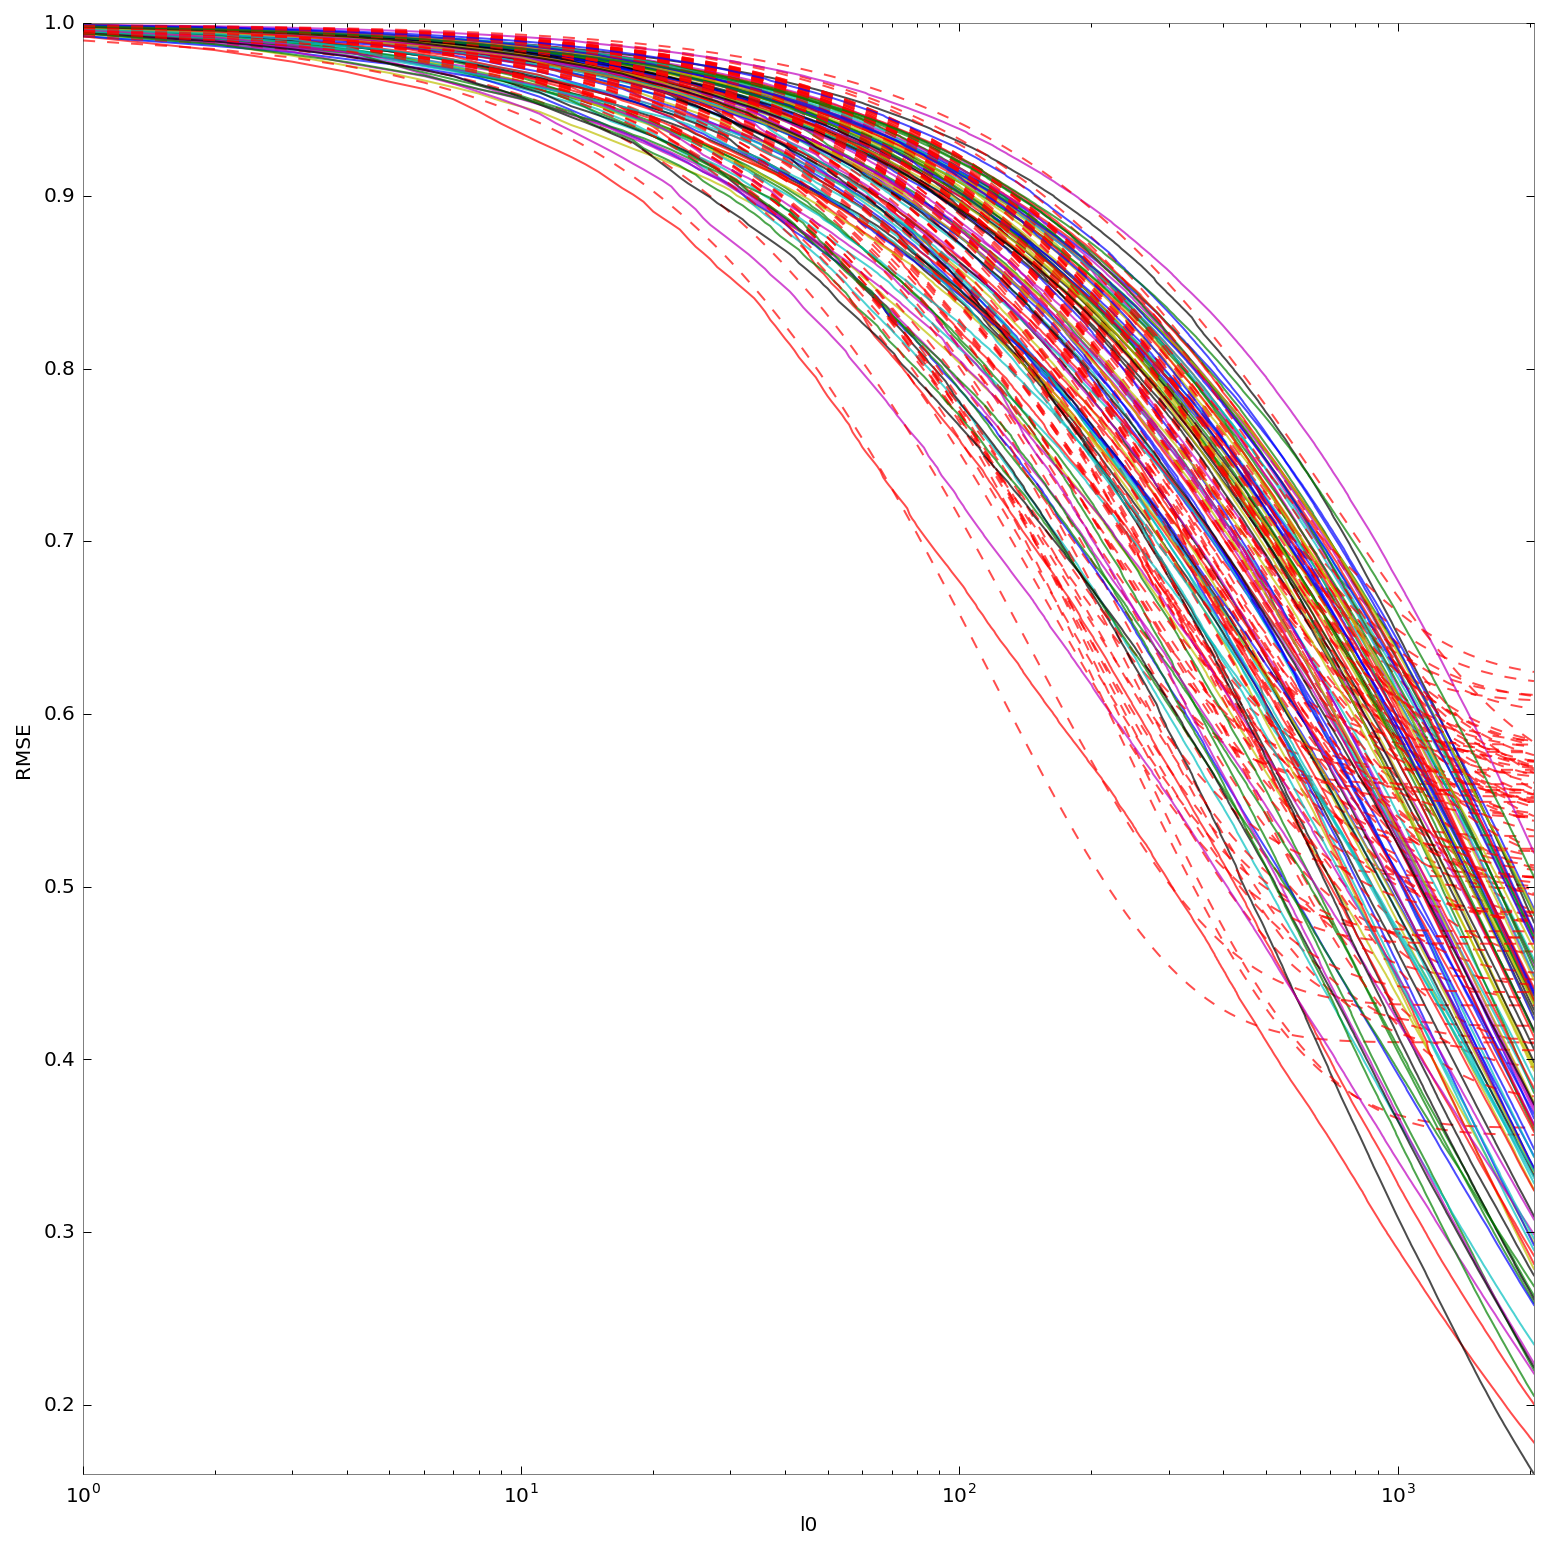

In [20]:
fig, A = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
#mod = PowerLawModel()
mod = ExpressionModel('1 - (1- eps_inf) * ( 1 - rho**(x+1))')

threshold = .5
verbose = False
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'eps_inf':.001, 'rho':.99}
    out  = mod.fit(RMSE[i_image, :], x=np.arange(N), verbose=verbose, weights=1/(np.arange(N)+1))
    #print(out.fit_report(min_correl=0.25))
    eps_inf = out.params.get('eps_inf').value
    rho =  out.params.get('rho').value
    #print rho, eps_inf
    N_theta = np.log((threshold-eps_inf)/(1-eps_inf))/np.log(rho)
    #print N_theta
    A.semilogx( RMSE[i_image, :], alpha=.7)
    params = mod.make_params(eps_inf=eps_inf, rho=rho)
    A.semilogx(mod.eval(params, x=np.arange(N)), 'r--', alpha=.7)
    A.set_xlabel('l0')
    A.axis('tight')
    A.axis('tight')
    _ = A.set_ylabel('RMSE')            


(100, 2048) (100, 2048)


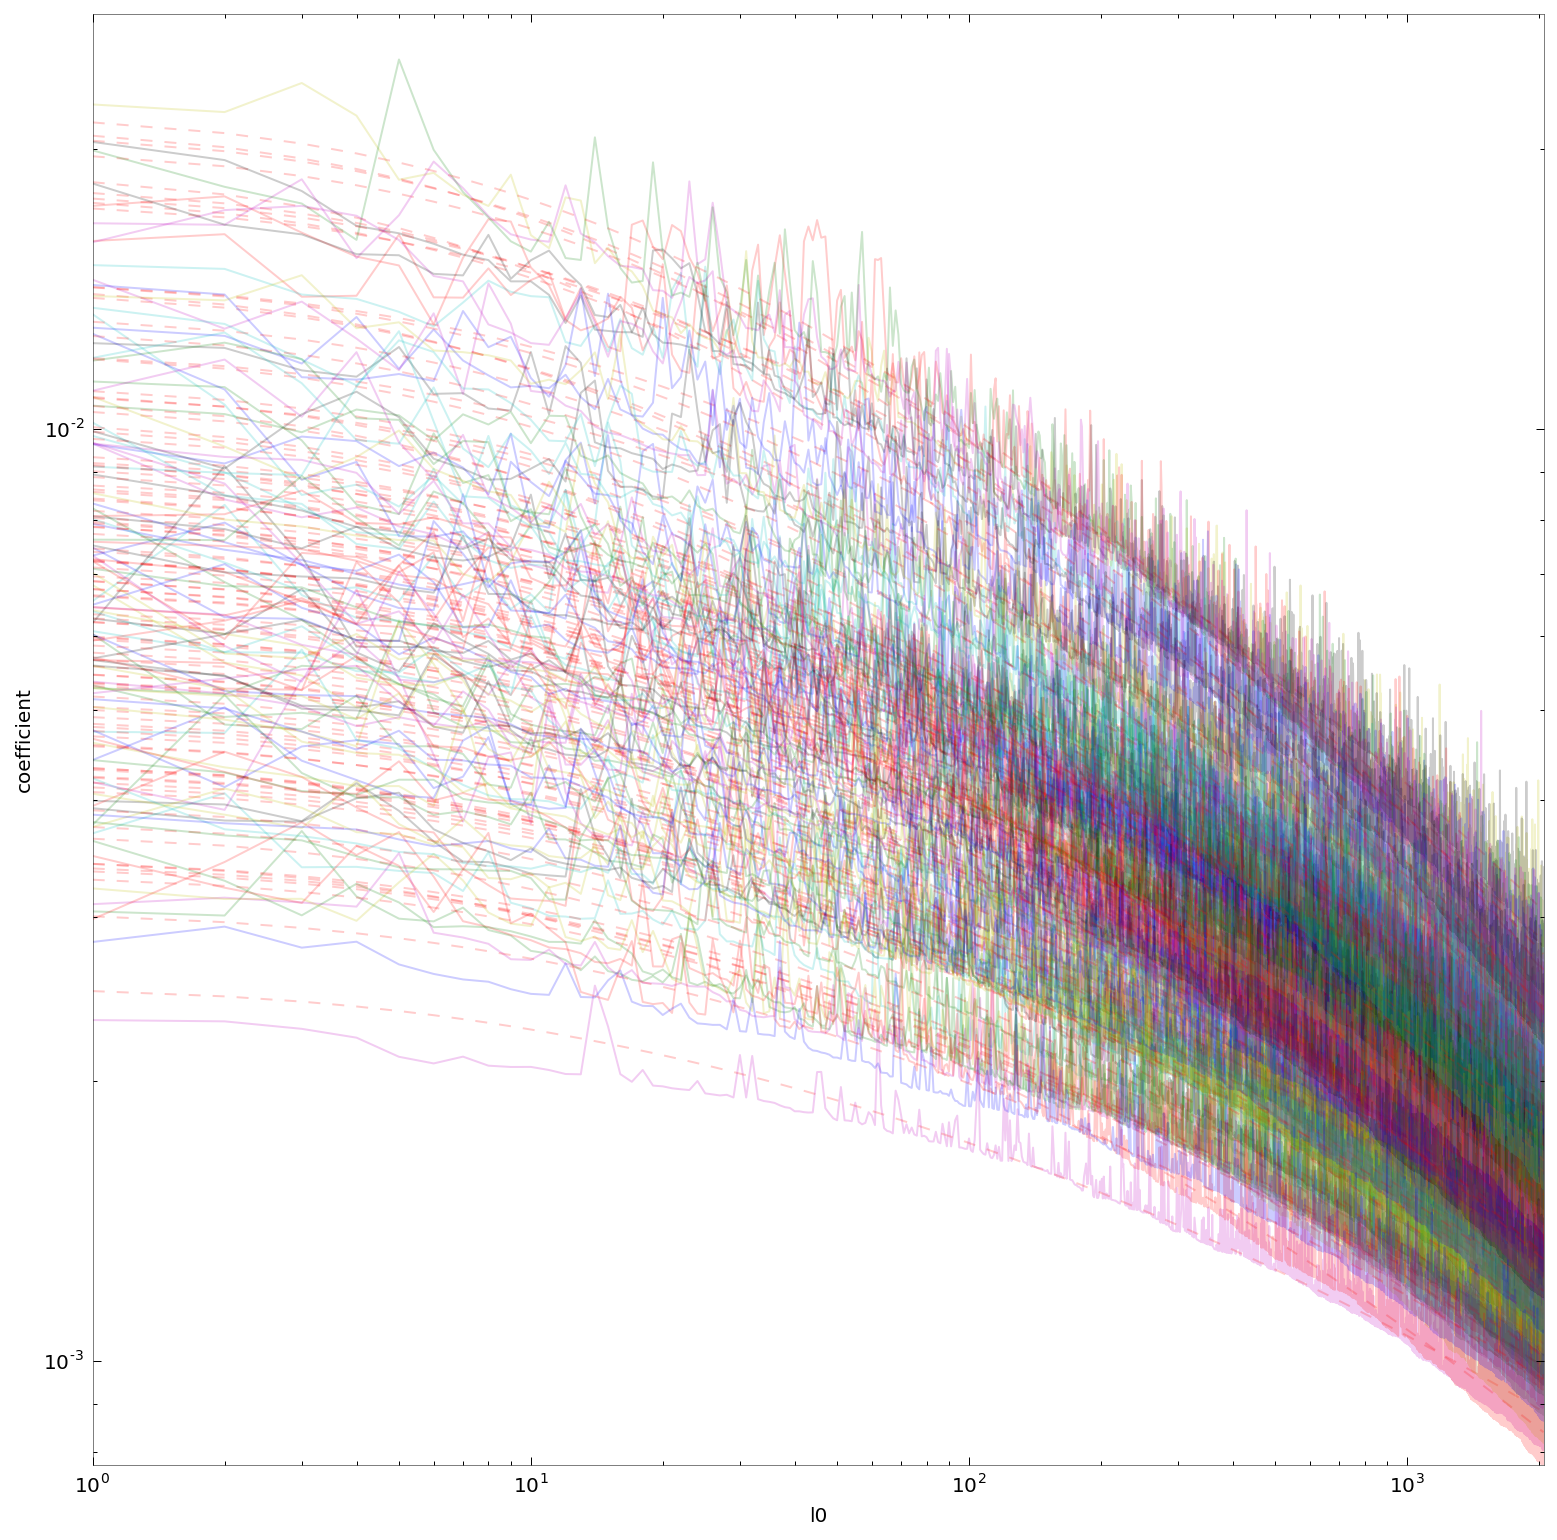

In [57]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...]
value /= RMSE[:, 0][np.newaxis, :]
#RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
value = value.T
print(value.shape, RMSE.shape)

fig, ax = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
from lmfit.models import PowerLawModel
#mod = PowerLawModel()
#mod = ExpressionModel('A* ( 1 -  ( 1 - rho**x))')
mod = ExpressionModel('amplitude * exp ( - .5 * log(x+1)**2 / rho **2 )')
verbose = False

for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'amplitude':.01, 'rho':100}
    out  = mod.fit(value[i_image, :], x=np.arange(N), verbose=verbose)
    #print(out.fit_report())
    amplitude = out.params.get('amplitude').value
    rho =  out.params.get('rho').value


(100, 2048) (100, 2048)


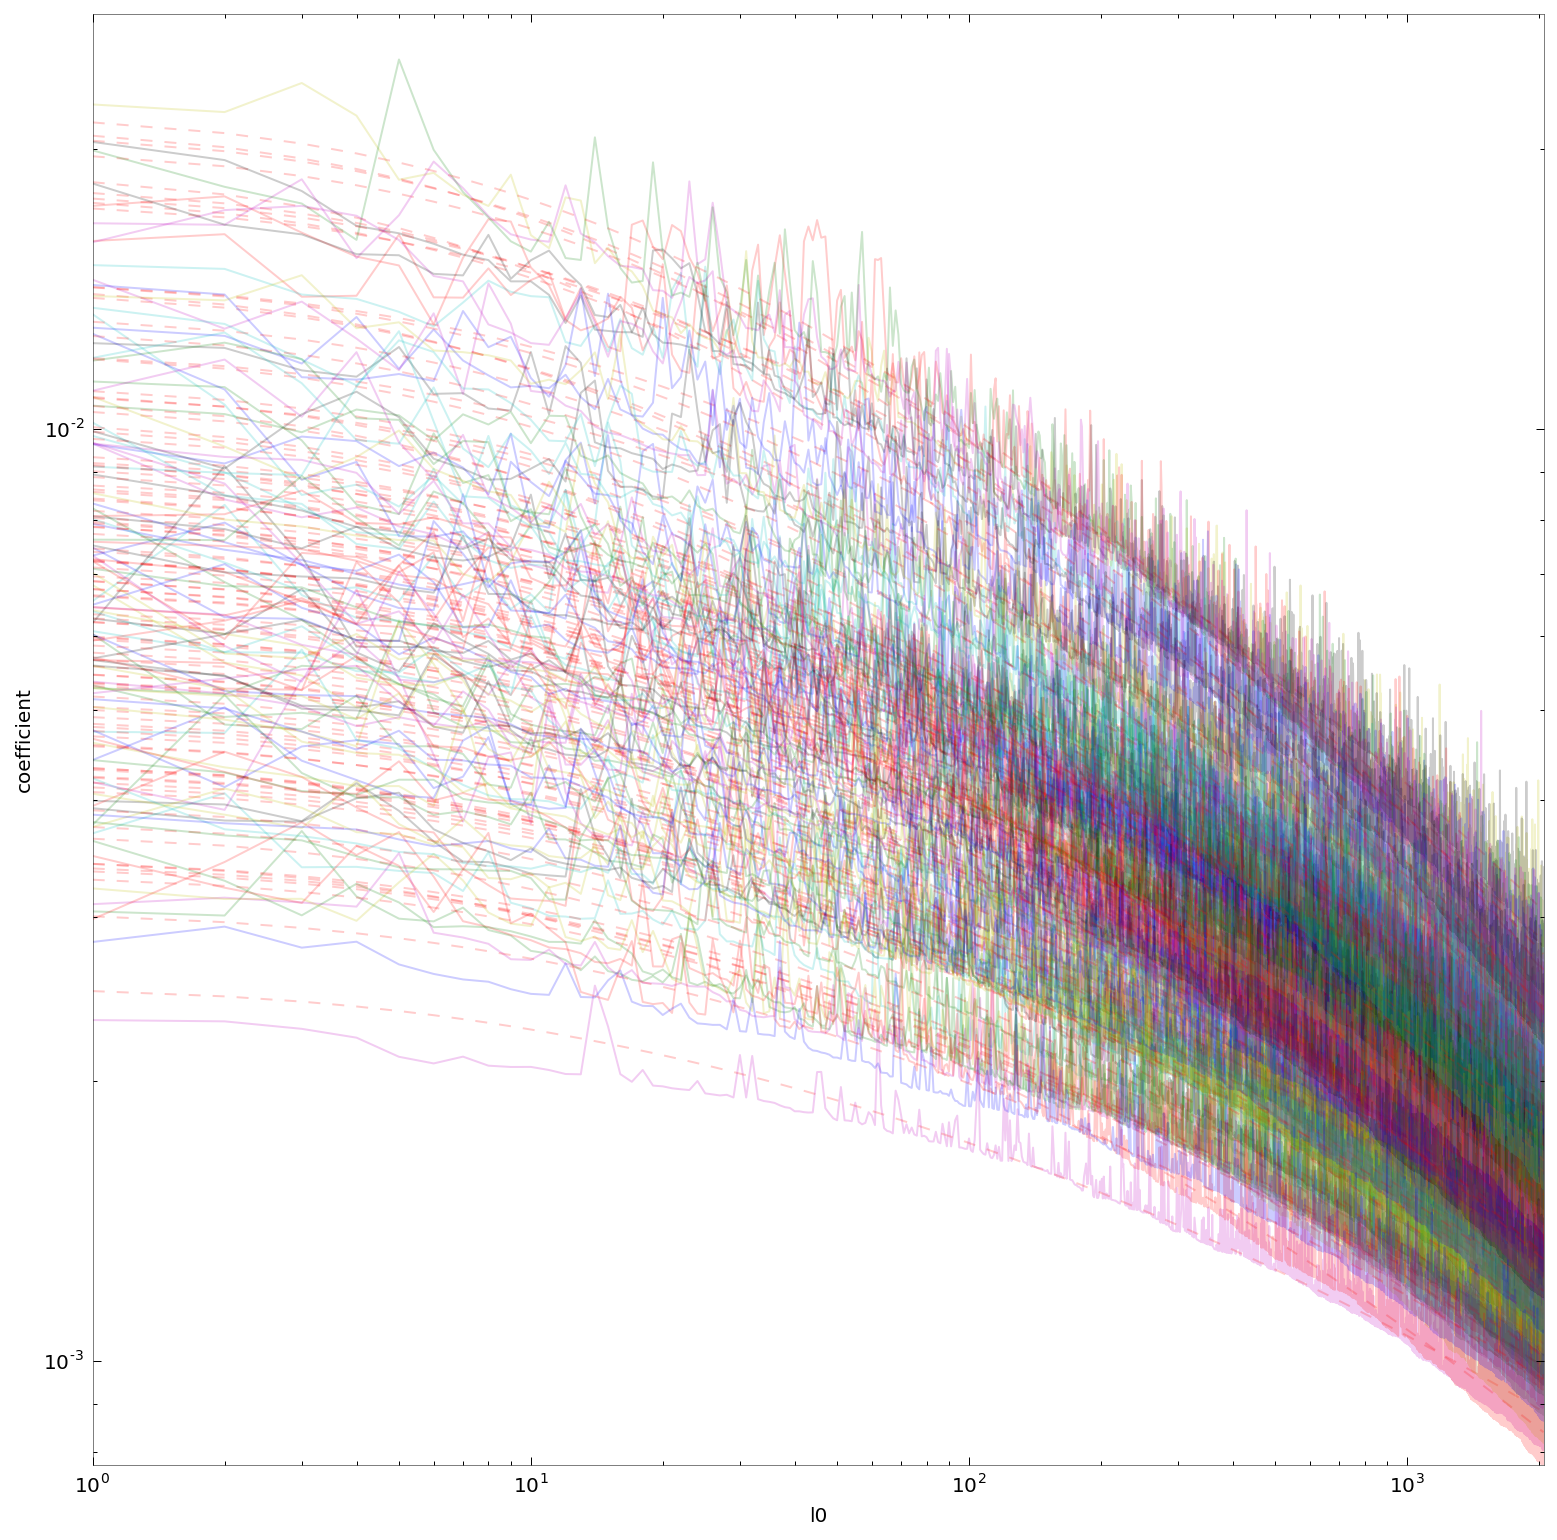

In [57]:
imagelist, edgeslist, RMSE = mp.process(exp=experiment, name_database=name_database)
value = edgeslist[4, ...]
value /= RMSE[:, 0][np.newaxis, :]
#RMSE /= RMSE[:, 0][:, np.newaxis]
N = RMSE.shape[1] #number of edges
value = value.T
print(value.shape, RMSE.shape)

fig, ax = plt.subplots(1, 1, figsize=(13, 13), subplot_kw={'axisbg':'w'})
from lmfit.models import ExpressionModel
from lmfit.models import PowerLawModel
#mod = PowerLawModel()
#mod = ExpressionModel('A* ( 1 -  ( 1 - rho**x))')
mod = ExpressionModel('amplitude * exp ( - .5 * log(x+1)**2 / rho **2 )')
verbose = False

for i_image in range(RMSE.shape[0]):
    #pars = mod.guess(RMSE[i_image, :], x=np.arange(N))
    mod.def_vals = {'amplitude':.01, 'rho':100}
    out  = mod.fit(value[i_image, :], x=np.arange(N), verbose=verbose)#, weights=np.exp(- np.arange(N) / 200))
    #print(out.params)
    #print(out.fit_report(min_correl=0.25))
    amplitude = out.params.get('amplitude').value
    rho =  out.params.get('rho').value

    ax.loglog( value[i_image, :], alpha=.2)
    params = mod.make_params(amplitude=amplitude, rho=rho)
    ax.loglog(mod.eval(params, x=np.arange(N)), 'r--', alpha=.2)
    ax.set_xlabel('l0')
    ax.axis('tight')
    _ = ax.set_ylabel('coefficient')            


## some book keeping for the notebook

In [56]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
09/05/2016 09:36:21

CPython 3.5.1
IPython 4.2.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)
system     : Darwin
release    : 15.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [57]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy

[autoreload of watermark failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'name'
]


Installed version_information.py. To use it, type:
  %load_ext version_information
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.1 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]
IPython 4.2.0
OS Darwin 15.4.0 x86_64 i386 64bit
numpy 1.11.0
scipy 0.17.0
matplotlib 1.5.1
sympy 1.0
Mon May 09 09:36:22 2016 CEST

In [55]:
%cd ../notebooks

/Users/laurentperrinet/pool/science/BICV/SparseEdges/notebooks
